In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### 0. Simulate phone dataset

Text(0.5, 1.0, 'Simulated dataset 400 points')

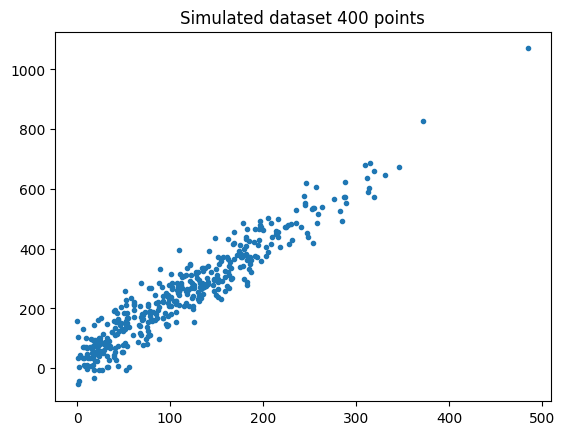

In [14]:
#a

np.random.seed(42)
samples = 400

X = abs(np.random.normal(loc = 100, scale = 100, size = samples))
epsilon = np.random.normal(loc=0, scale=50, size=samples)

y = 25 + 2 * X + epsilon

plt.plot(X, y, '.')
plt.title("Simulated dataset 400 points")